In [57]:
'''A hacked together version of IF2 to use as a proof of concept for 
possible implementation in epymorph.'''

'A hacked together version of IF2 to use as a proof of concept for \npossible implementation in epymorph.'

In [58]:
import numpy as np
from epymorph.forecasting.likelihood import Poisson

from epymorph.forecasting.param_transformations import ExponentialTransform
from epymorph.forecasting.dynamic_params import GaussianPrior,BrownianMotion, OrnsteinUhlenbeck

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
    UnknownParam
)

from epymorph.attribute import NamePattern
from epymorph.kit import *
from epymorph.adrio import acs5, us_tiger
import matplotlib.pyplot as plt


In [59]:
my_rng = np.random.default_rng(0)
sim_time_frame = TimeFrame.of("2015-01-01", 150)
pf_scope = CountyScope.in_states(["AZ"],year=2015)

#beta and gamma
beta = np.array([0.4,0.5,0.6,0.8,0.55,0.3,0.7,0.25,0.9,0.28,0.3,0.4,0.52,0.15,0.35])

rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=pf_scope,
    # Create a SingleLocation initializer
    init=init.SingleLocation(location=0, seed_size=100),
    # Set the time-frame to simulate
    time_frame=sim_time_frame,
    # Provide model parameter values
    params={
        "beta": beta,
        "gamma":0.1,
        "xi":1/90,
        "phi":20,
        "hospitalization_prob":0.01,
        "hospitalization_duration":5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

In [60]:

# Construct a simulator for the RUME
sim = BasicSimulator(rume)

# Run inside a sim_messaging context to display a nice progress bar
with sim_messaging():
    # Run and save the simulation Output object for later
    out = sim.run(
        # Use a seeded RNG (for the sake of keeping this notebook's results consistent)
        # This parameter is optional; by default a new RNG is constructed for each run
        # using numpy's default_rng
        rng_factory=lambda: my_rng
    )

Loading gpm:all::mm::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.565s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-30 (150 days)
• 15 geo nodes
  |####################| 100%                     
Runtime: 0.583s


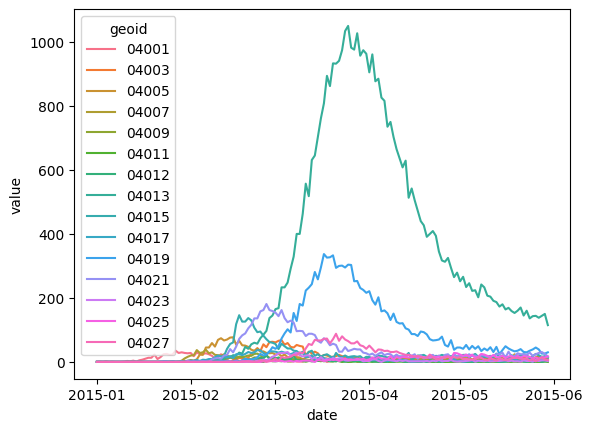

In [61]:
# Plot the compartment values in States throughout the simulation.
from epymorph.adrio import csv
from epymorph.tools.data import munge
import seaborn as sns


cases_df = munge(
    out,
    quantity=rume.ipm.select.events("I->H"),
    time=rume.time_frame.select.all().group("day").agg(),
    geo=rume.scope.select.all(),
)

cases_df.columns = ['date','geoid','value']

sns.lineplot(data=cases_df,x='date',y='value',hue='geoid')

cases_df.to_csv('pf_vignettes/synthetic_data.csv',index=False)

csvadrio = csv.CSVFileAxN(
    file_path='pf_vignettes/synthetic_data.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)


In [62]:
num_realizations = 100

pf_rume = SingleStrataRUME.build(
    # Load the Pei IPM
    ipm=ipm.SIRH(),
    # Load the Pei MM
    mm=mm.Centroids(),
    # Describe the geographic scope of our simulation:
    scope=pf_scope,
    # Create a SingleLocation initializer
    init=init.RandomLocationsAndRandomSeed(1,1000),
    # Set the time-frame to simulate
    time_frame=TimeFrame.of("2015-01-01", 150),
    # Provide model parameter values
    params={
        "beta": ExponentialTransform('log_beta'),
        "gamma": 0.1,
        "xi":1/90,
        "phi":20,
        "hospitalization_prob":0.01,
        "hospitalization_duration":5,
        # Geographic data can be loaded using ADRIOs
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population()
    },
)

my_observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        geo=pf_rume.scope.select.all(),
        time=pf_rume.time_frame.select.all().group("day").agg(),
        quantity=pf_rume.ipm.select.events("I->H"),
    ),
    likelihood=Poisson(),
)


In [63]:
from time import perf_counter

outer_loop_iterations = 50
scale = 0.02
Vn = scale**2 * np.eye(pf_rume.scope.nodes) #Covariance matrix of the parameter perturbations
cooling_schedule = np.flip(np.linspace(0.01,1.0,outer_loop_iterations))

#Initialize the parameters
params = my_rng.multivariate_normal(np.log(0.5) * np.ones(pf_rume.scope.nodes),Vn,size = (num_realizations))

for iter in range(outer_loop_iterations): 

    # Draw random normal variates
    cov_sqrt = np.linalg.cholesky(cooling_schedule[iter] * Vn)
    std_vars = my_rng.normal(size = params.shape)

    #Particle info
    params = params + std_vars @ cov_sqrt.T

    my_unknown_params = {
        "log_beta": UnknownParam(
        prior=params,
        dynamics=BrownianMotion(
           voliatility = cooling_schedule[iter] * scale 
        ))
        }

    particle_filter_simulator = ParticleFilterSimulator(
            config=FromRUME(pf_rume,num_realizations,unknown_params = my_unknown_params),
            observations=my_observations,
            save_trajectories=True,
        )

    particle_filter_output = particle_filter_simulator.run(rng=my_rng)

    params = particle_filter_output.estimated_params[NamePattern.of("log_beta")][:,-1,:]

    #np.array([0.4,0.5,0.6,0.8,0.55,0.3,0.7,0.25,0.9,0.28,0.3,0.4,0.52,0.15,0.35])
    print(f"Mean of params(betas): {np.exp(np.mean(params,axis = 0))}")


Mean of params(betas): [0.42360221 0.52053335 0.5816128  0.65212825 0.63299697 0.35807524
 0.54950309 0.32653215 0.63514855 0.34701074 0.30625242 0.39110251
 0.51396966 0.42748178 0.38718642]
Mean of params(betas): [0.44981639 0.50201636 0.58726289 0.81116421 0.57439454 0.32454169
 0.78469594 0.25243082 0.85635102 0.29411677 0.29275955 0.4004041
 0.52104504 0.39365915 0.36572368]
Mean of params(betas): [0.46745747 0.52698097 0.56348578 0.73227307 0.64612968 0.28169931
 0.6507824  0.25445948 1.03766878 0.29622464 0.28738352 0.40079056
 0.5106847  0.18962344 0.35224369]
Mean of params(betas): [0.47261999 0.52268321 0.60594182 0.78728929 0.5351545  0.26886973
 0.73406227 0.26604827 0.98977997 0.29058238 0.29024162 0.4077913
 0.52364708 0.14315346 0.37594993]
Mean of params(betas): [0.41383221 0.53126067 0.54538743 0.91262067 0.59155946 0.29078377
 0.66345649 0.26217517 1.03864429 0.2647813  0.28987979 0.39770372
 0.62716644 0.14279104 0.32966158]
Mean of params(betas): [0.43946843 0.48764

In [70]:
import pandas as pd

pf_betas = pd.DataFrame({'inferred': [0.37178708, 0.51444534, 0.59424776, 0.76952471, 0.5621738,  0.2887934,
 0.67199302, 0.25010444, 0.87290599, 0.26660866, 0.30017275, 0.40194626,
 0.52497614, 0.15002977, 0.36378027],
 'true': [0.4,0.5,0.6,0.8,0.55,0.3,0.7,0.25,0.9,0.28,0.3,0.4,0.52,0.15,0.35],'geo':pf_scope.labels})

pf_betas['abs_err'] = np.abs(pf_betas['inferred'] - pf_betas['true'])
pf_betas['rel_err_percent'] = 100 * (np.abs(pf_betas['inferred'] - pf_betas['true'])/pf_betas['true'])
pf_betas

,inferred,true,geo,abs_err,rel_err_percent
0,0.371787,0.40,"Apache, AZ",0.028213,7.053230
1,0.514445,0.50,"Cochise, AZ",0.014445,2.889068
2,0.594248,0.60,"Coconino, AZ",0.005752,0.958707
3,0.769525,0.80,"Gila, AZ",0.030475,3.809411
4,0.562174,0.55,"Graham, AZ",0.012174,2.213418
5,0.288793,0.30,"Greenlee, AZ",0.011207,3.735533
6,0.671993,0.70,"La Paz, AZ",0.028007,4.000997
7,0.250104,0.25,"Maricopa, AZ",0.000104,0.041776
8,0.872906,0.90,"Mohave, AZ",0.027094,3.010446
9,0.266609,0.28,"Navajo, AZ",0.013391,4.782621
